In [13]:
'''this notebook is for cleaning the corrected pixel count csv'''
import pandas as pd 

df = pd.read_csv("pixel_count_corrected.csv") #this one has the pixel values of the masks when corrected using AI via linear correction
df.head()

,FileName,Frame,PixelCount,OriginalPixelCount,PixelIncrease,PercentIncrease,CorrectionMethod,KernelSize,Iterations
0,0X100009310A3BD7FC.avi,46,1744,1348,396,29.376855,morphological_dilation,3,2
1,0X100009310A3BD7FC.avi,61,854,543,311,57.274401,morphological_dilation,3,2
2,0X1002E8FBACD08477.avi,3,1593,1225,368,30.040816,morphological_dilation,3,2
3,0X1002E8FBACD08477.avi,18,960,680,280,41.176471,morphological_dilation,3,2
4,0X1005D03EED19C65B.avi,24,1166,842,324,38.479810,morphological_dilation,3,2


In [14]:
#group rows by filename 
import pandas as pd

df = pd.read_csv("pixel_count_corrected.csv")

# Group by FileName and find min/max pixel counts with corresponding frames
grouped_results = []

for filename, group in df.groupby('FileName'):
    # Find indices of min and max pixel counts
    min_idx = group['PixelCount'].idxmin()
    max_idx = group['PixelCount'].idxmax()
    
    # Get the corresponding rows
    min_row = group.loc[min_idx]
    max_row = group.loc[max_idx]
    
    # Create summary record
    result = {
        'FileName': filename,
        'ESV_corrected': min_row['PixelCount'],
        'ESC_corrected_frame': min_row['Frame'],
        'EDV_corrected': max_row['PixelCount'],
        'EDV_corrected_frame': max_row['Frame'],
        'PixelDifference': max_row['PixelCount'] - min_row['PixelCount'],
        'TotalFrames': len(group)
    }
    
    grouped_results.append(result)

# Convert to DataFrame
result_df = pd.DataFrame(grouped_results)

# Display results
print(f"Found {len(result_df)} unique videos")
print("\nSample results:")
print(result_df.head(10))

# Save results
result_df.to_csv("pixel_values_corrected.csv", index=False)
print(f"\n Results saved to 'pixel_values_corrected.csv'")

# Show some statistics
print(f"\nStatistics:")
print(f"Average pixel difference: {result_df['PixelDifference'].mean():.1f}")
print(f"Average frames per video: {result_df['TotalFrames'].mean():.1f}")
print(f"Min pixel count range: {result_df['ESV_corrected'].min()} - {result_df['ESV_corrected'].max()}")
print(f"Max pixel count range: {result_df['EDV_corrected'].min()} - {result_df['EDV_corrected'].max()}")

Found 10025 unique videos

Sample results:
                 FileName  ESV_corrected  ESC_corrected_frame  EDV_corrected  \
0  0X100009310A3BD7FC.avi            854                   61           1744   
1  0X1002E8FBACD08477.avi            960                   18           1593   
2  0X1005D03EED19C65B.avi            728                   35           1166   
3  0X10075961BC11C88E.avi            997                  108           1445   
4  0X10094BA0A028EAC3.avi           2077                  156           2514   
5  0X100CF05D141FF143.avi           1117                  148           1719   
6  0X100E3B8D3280BEC5.avi           1273                   38           1657   
7  0X100E491B3CD58DE2.avi           1403                   75           1739   
8  0X100F044876B98F90.avi            972                   72           1622   
9  0X101026B90DAE7E95.avi           1589                   62           2180   

   EDV_corrected_frame  PixelDifference  TotalFrames  
0                   4

In [15]:
''' add the other df so we can compare
this csv has the original volume tracings value vs the pixel-derived values from creating the mask
note that the mask pixel values were **NOT** corrected using AI'''
df_non_corrected = pd.read_csv("pixel_vs_gt_values.csv") 
df_non_corrected.head()

,Key,ESV_pixel,EDV_pixel,EF_pixel,ESV_gt,EDV_gt,EF_gt,EF_error
0,0X100009310A3BD7FC,543,1348,59.718101,14.881368,69.210534,78.498406,-18.780305
1,0X1002E8FBACD08477,680,1225,44.489796,40.383876,98.742884,59.101988,-14.612192
2,0X1005D03EED19C65B,472,842,43.942993,14.267784,37.909734,62.363798,-18.420806
3,0X10075961BC11C88E,705,1109,36.429216,33.143084,72.914210,54.545097,-18.115881
4,0X10094BA0A028EAC3,1677,2070,18.985507,127.581945,169.855024,24.887742,-5.902234


In [16]:
import pandas as pd
complete_df = pd.read_csv("enhanced_pixel_vs_gt_with_corrected.csv")
complete_df.columns


Index(['Key', 'ESV_pixel', 'EDV_pixel', 'ESV_gt', 'EDV_gt', 'EF_gt',
       'EF_pixel', 'EF_error', 'ESV_corrected', 'EDV_corrected',
       'ESC_corrected_frame', 'EDV_corrected_frame', 'EF_corrected',
       'EF_error_corrected'],
      dtype='object')

In [17]:
'''just compare relevant columns'''
select_df = complete_df[["Key", 'EF_gt', 'EF_pixel','EF_corrected']]

select_df.head()

,Key,EF_gt,EF_pixel,EF_corrected
0,0X100009310A3BD7FC,78.498406,59.718101,51.032110
1,0X1002E8FBACD08477,59.101988,44.489796,39.736347
2,0X1005D03EED19C65B,62.363798,43.942993,37.564322
3,0X10075961BC11C88E,54.545097,36.429216,31.003460
4,0X10094BA0A028EAC3,24.887742,18.985507,17.382657


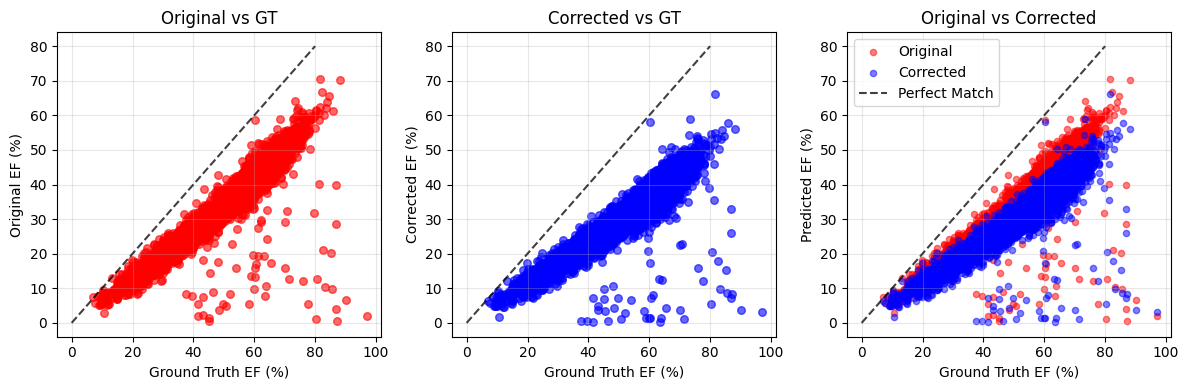

Using mean abs error (MAE) to calculate the average prediction. I.e if MAE = 10, then on avg predictions are off 10 points from GT vals
Non-corrected/Original Mask MAE: 17.2%
Corrected Mask MAE: 22.2%


In [18]:
'''compare the EF_pixel and EF_corrected against the EF_gt
just visually inspecting the dataframe shows that despite the AI using correction to increase the ESV and EDV pixel count for the masks
it only resulted in a lower EF compared to the non-corrected
and this tracks because EF is calculated with the proportion of the EDV and ESV, so '''

import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(12, 4))

# plot the original (non corr masks pixel value for EF vs the ground truth % value for EF from Volume tracings
plt.subplot(1, 3, 1)
plt.scatter(select_df['EF_gt'], select_df['EF_pixel'], alpha=0.6, color='red', s=30)
plt.plot([0, 80], [0, 80], 'k--', alpha=0.75)
plt.xlabel('Ground Truth EF (%)') #derived from volumetracings and filelist.csv from EchoNet
plt.ylabel('Original EF (%)') #derived by calc. ef using simpsons method from mask values
plt.title('Original vs GT')
plt.grid(True, alpha=0.3)

# plot of the corrected mask values for EF vs the ground truth values
plt.subplot(1, 3, 2)
plt.scatter(select_df['EF_gt'], select_df['EF_corrected'], alpha=0.6, color='blue', s=30)
plt.plot([0, 80], [0, 80], 'k--', alpha=0.75)
plt.xlabel('Ground Truth EF (%)') #ground truth vals
plt.ylabel('Corrected EF (%)') #calculated from the corrected values using simpsons method
plt.title('Corrected vs GT')
plt.grid(True, alpha=0.3)

# plot both together just to see the difference
plt.subplot(1, 3, 3)
plt.scatter(select_df['EF_gt'], select_df['EF_pixel'], alpha=0.5, color='red', s=20, label='Original')
plt.scatter(select_df['EF_gt'], select_df['EF_corrected'], alpha=0.5, color='blue', s=20, label='Corrected')
plt.plot([0, 80], [0, 80], 'k--', alpha=0.75, label='Perfect Match')
plt.xlabel('Ground Truth EF (%)')
plt.ylabel('Predicted EF (%)')
plt.title('Original vs Corrected')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("Using mean abs error (MAE) to calculate the average prediction. I.e if MAE = 10, then on avg predictions are off 10 points from GT vals")
print(f"Non-corrected/Original Mask MAE: {abs(select_df['EF_pixel'] - select_df['EF_gt']).mean():.1f}%")
print(f"Corrected Mask MAE: {abs(select_df['EF_corrected'] - select_df['EF_gt']).mean():.1f}%")
